Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing Skin Cancer Data**

### **Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
# Import dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Upgrad/skin_cancer/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Upgrad/skin_cancer/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width)
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width)
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

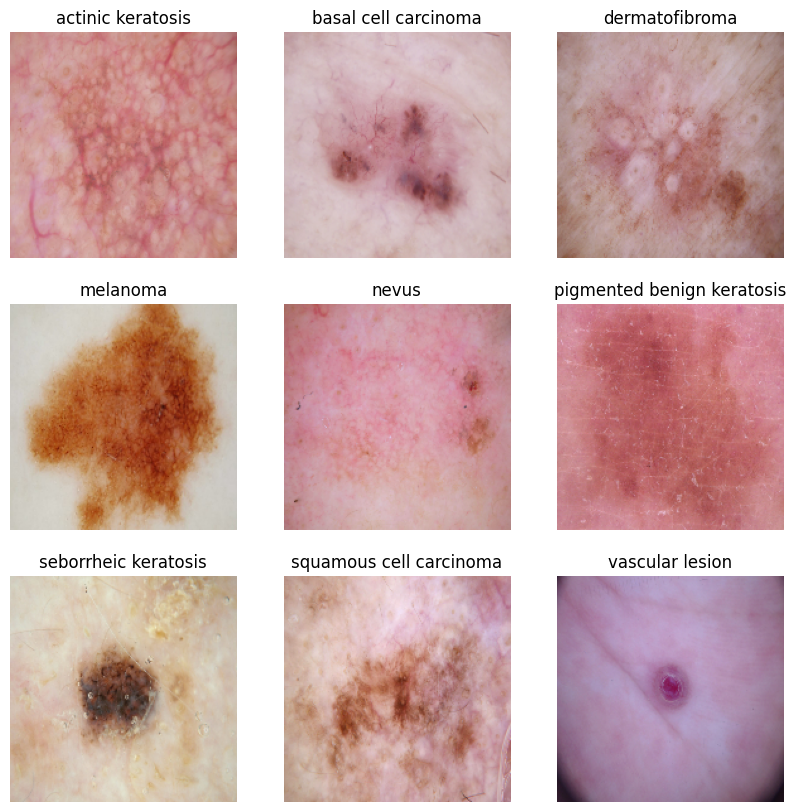

In [9]:
import matplotlib.pyplot as plt

# Create a dictionary to store one image per class
class_images = {class_name: None for class_name in train_ds.class_names}

# Iterate through the dataset until we have one image per class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = train_ds.class_names[label]
        if class_images[class_name] is None:
            class_images[class_name] = image
        if None not in class_images.values():
            break
    if None not in class_images.values():
        break

# Plot one image from each class
plt.figure(figsize=(10, 10))
for i, (class_name, image) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Let us see how we can normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.08398642 0.96568525


In [13]:
# We will define the normalization layer in the model
# We will use 3 convolution layers  with Max Pooling

num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
# We will use adam optimizer and Sparse Categorical Cross Entropy loss function

model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Train the model

In [15]:
# We will train the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 201s 4s/step - loss: 2.1923 - accuracy: 0.2093 - val_loss: 1.9449 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 61s 1s/step - loss: 1.8141 - accuracy: 0.3320 - val_loss: 1.6584 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 60s 1s/step - loss: 1.5693 - accuracy: 0.4464 - val_loss: 1.4765 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 62s 1s/step - loss: 1.4102 - accuracy: 0.5022 - val_loss: 1.4617 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 65s 1s/step - loss: 1.3472 - accuracy: 0.5273 - val_loss: 1.4484 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 61s 1s/step - loss: 1.2713 - accuracy: 0.5608 - val_loss: 1.4246 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.1921 - accuracy: 0.5759 - val_loss: 1.3556 - val_accuracy: 0.5302
Epoch 8/20
56/56 [=

In [16]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Visualizing training results

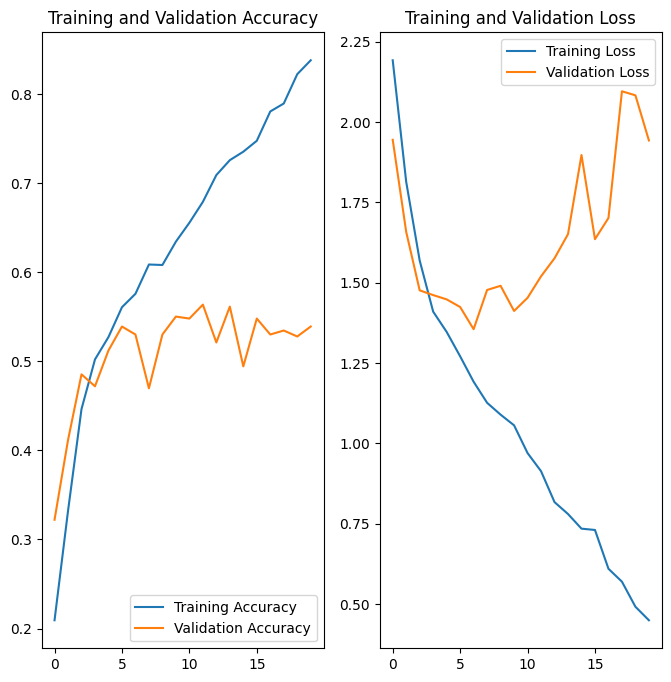

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


Clearly the model is overfitting as the training accuracy is ~83% while validation accuracy is only ~53%

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Let us try different augmentation techniques like flipping, rotation and zooming to see if they can  help solve the overfitting issue

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

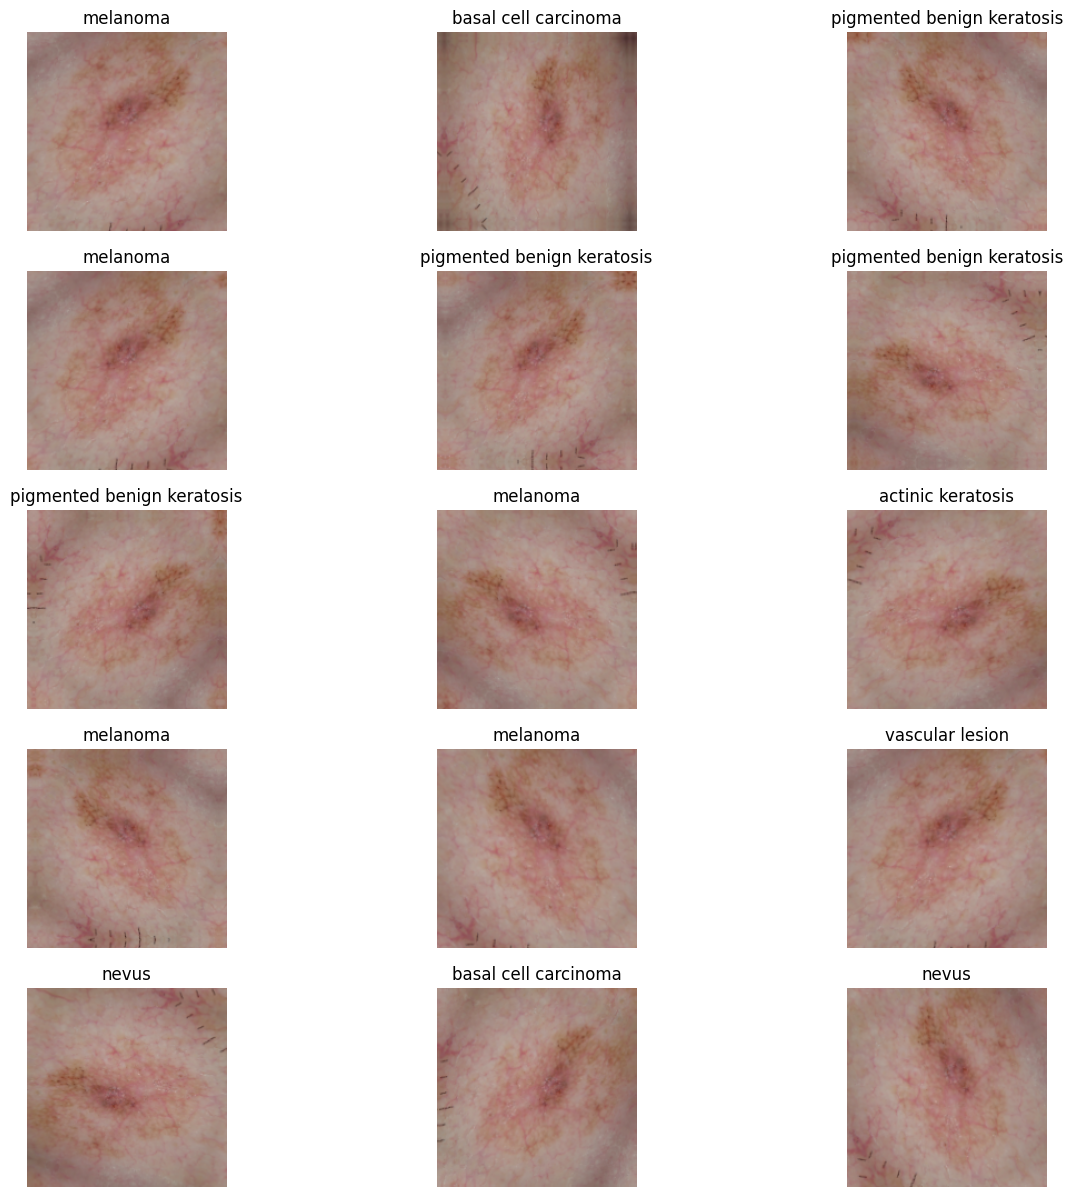

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
# You can use Dropout layer if there is an evidence of overfitting in your findings
# Now let us create a new model with augmentation added

num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


### Compiling the model

In [21]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Training the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 97s 2s/step - loss: 2.3343 - accuracy: 0.1780 - val_loss: 2.0438 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 79s 1s/step - loss: 1.9182 - accuracy: 0.2930 - val_loss: 1.9041 - val_accuracy: 0.3311
Epoch 3/20
56/56 [==============================] - 77s 1s/step - loss: 1.7356 - accuracy: 0.3717 - val_loss: 1.6573 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 77s 1s/step - loss: 1.5926 - accuracy: 0.4308 - val_loss: 1.5996 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 77s 1s/step - loss: 1.5216 - accuracy: 0.4520 - val_loss: 1.5392 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 76s 1s/step - loss: 1.4741 - accuracy: 0.4810 - val_loss: 1.4681 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 71s 1s/step - loss: 1.4206 - accuracy: 0.4922 - val_loss: 1.5247 - val_accuracy: 0.4832
Epoch 8/20
56/56 [==

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                 

### Visualizing the results

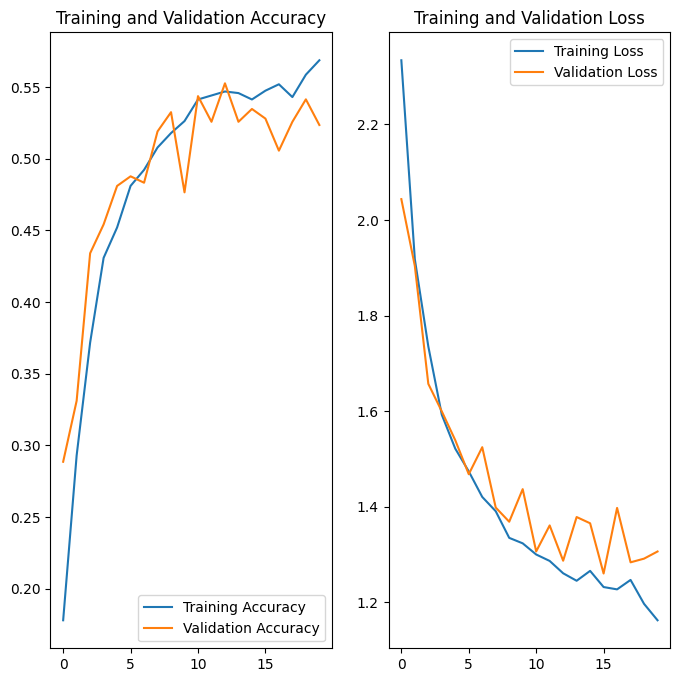

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Clealy we have made significant improvement in overfitting.   
As seen above validation accurancy is very close to the training accuracy  

However we can see that model is still having very low accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


#### **Todo:** Write your findings here:
From the table here we can clearly see we have a case of class imbalance
#### - Which class has the least number of samples?
seborrheic keratosis has least number of samples at 77
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis has the largest number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
import Augmentor

path_to_training_dataset= '/content/gdrive/MyDrive/Upgrad/skin_cancer/Train/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/'+i+'/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C67B7C100>: 100%|██████████| 500/500 [00:22<00:00, 21.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C6794BCD0>: 100%|██████████| 500/500 [00:25<00:00, 19.81 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C74B6FCD0>: 100%|██████████| 500/500 [00:23<00:00, 20.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/melanoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1C67D3FE50>: 100%|██████████| 500/500 [01:47<00:00,  4.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/nevus/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1C626A1D80>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C67BB47C0>: 100%|██████████| 500/500 [00:25<00:00, 19.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/seborrheic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1C67D3FD90>: 100%|██████████| 500/500 [00:48<00:00, 10.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C67AC2EF0>: 100%|██████████| 500/500 [00:24<00:00, 20.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/vascular lesion/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C6794B7F0>: 100%|██████████| 500/500 [00:22<00:00, 21.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
from glob import glob

train_dir =  pathlib.Path('/content/gdrive/MyDrive/Upgrad/Skin_Cancer/Train/')
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(train_dir.glob(name+'/*.jpg')))
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [31]:
data_dir_train = train_dir
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width)
    )

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width)
    )

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [34]:
## your code goes here
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
113/113 [==============================] - 195s 1s/step - loss: 2.2601 - accuracy: 0.1653 - val_loss: 2.0112 - val_accuracy: 0.2344
Epoch 2/20
113/113 [==============================] - 141s 1s/step - loss: 1.8092 - accuracy: 0.2953 - val_loss: 1.8310 - val_accuracy: 0.2933
Epoch 3/20
113/113 [==============================] - 137s 1s/step - loss: 1.5503 - accuracy: 0.4167 - val_loss: 1.4592 - val_accuracy: 0.4767
Epoch 4/20
113/113 [==============================] - 136s 1s/step - loss: 1.3343 - accuracy: 0.5244 - val_loss: 1.3316 - val_accuracy: 0.5178
Epoch 5/20
113/113 [==============================] - 145s 1s/step - loss: 1.1975 - accuracy: 0.5625 - val_loss: 1.2203 - val_accuracy: 0.5600
Epoch 6/20
113/113 [==============================] - 136s 1s/step - loss: 1.0876 - accuracy: 0.6003 - val_loss: 1.1878 - val_accuracy: 0.5722
Epoch 7/20
113/113 [==============================] - 139s 1s/step - loss: 0.9777 - accuracy: 0.6517 - val_loss: 1.1436 - val_accuracy: 0.5933

#### **Todo:**  Visualize the model results

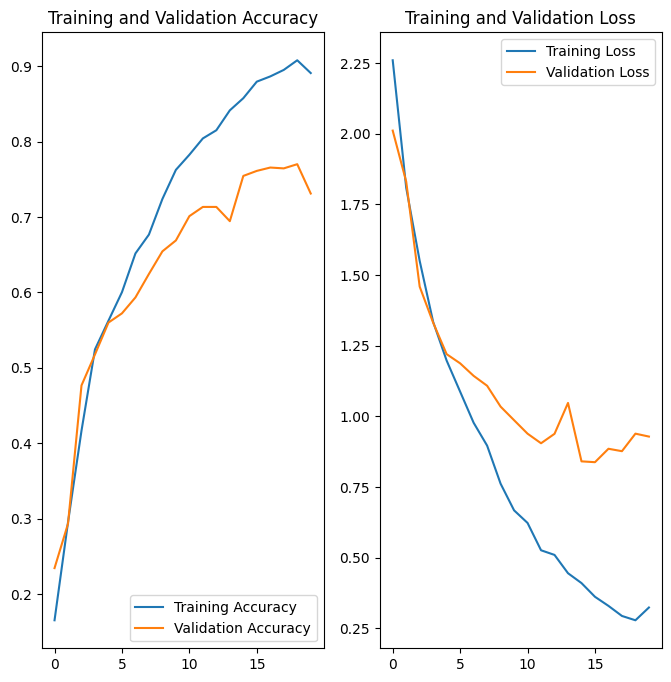

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



As seen above we could significantly reduce both overfitting and  underfitting.   
Training accuracy and Validation accuracy are at 89% and 73% respectively